Find tail beat wavelength extremes, plot the results, and evaluate against ground truth

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
base = os.getcwd()
sys.path.append(base)
sys.path.append(base + '\\helpers')

from file_utils import load_txt_data_for_eval, read_config
from comp_utils import get_salmon_ID_and_comp_type_from_comp_ID
from hq_track_utils import *
from welfare_helpers.welfare_helpers import *



In [2]:
results_path = "C:\\Users\\espen\\Documents\\work\\PhD\\papers\\salmon_tracking\\data\\datasets\\without_boxes\\TBW_val\\associator\\BoostCompTrack\\output\\salmon_tracking\\analysis1\\MOT_results.txt"
imgs_folder = "C:\\Users\\espen\\Documents\\work\\PhD\\papers\\salmon_tracking\\data\\datasets\\without_boxes\\TBW_val\\20230309_135916_cage15_t0x_yz"
gt_path = "C:\\Users\\espen\\Documents\\work\\PhD\\papers\\salmon_tracking\\data\\datasets\\without_boxes\\TBW_val\\20230309_135916_cage15_t0x_yz.xlsx"


In [3]:
# Load trackers
trackers = load_txt_data_for_eval(results_path)[:,:11]
trackers[:,1],_ = get_salmon_ID_and_comp_type_from_comp_ID(trackers[:,1].astype(float).astype(int),9)

In [4]:
# Extract high-quality tracks
config = read_config(os.path.join(os.path.dirname(results_path), 'config.yml'))
verbose = False
num_thresh = 50

trackers, id_cnt_dict = remove_incomplete_salmon(trackers, config, verbose=verbose, ncomp = 9, size_thresh = 200)
trackers = remove_small_salmon(trackers, config, id_cnt_dict, num_thresh=num_thresh, verbose=verbose)
trackers, valid_ids = remove_non_consecutive_tracks(trackers, num_thresh=num_thresh,verbose=verbose)

In [5]:
# Create data for annotation
# create_data_for_GT_labeling(trackers, config, imgs_folder)

TP
tip 66.0
salmon_width 42.5
tailfin_width 63.25


FP
tip 34.0
salmon_width 56.5
tailfin_width 37.75


FN
tip 33.0
salmon_width 56.5
tailfin_width 35.75


Total
tip 100.0
salmon_width 99.0
tailfin_width 101.0




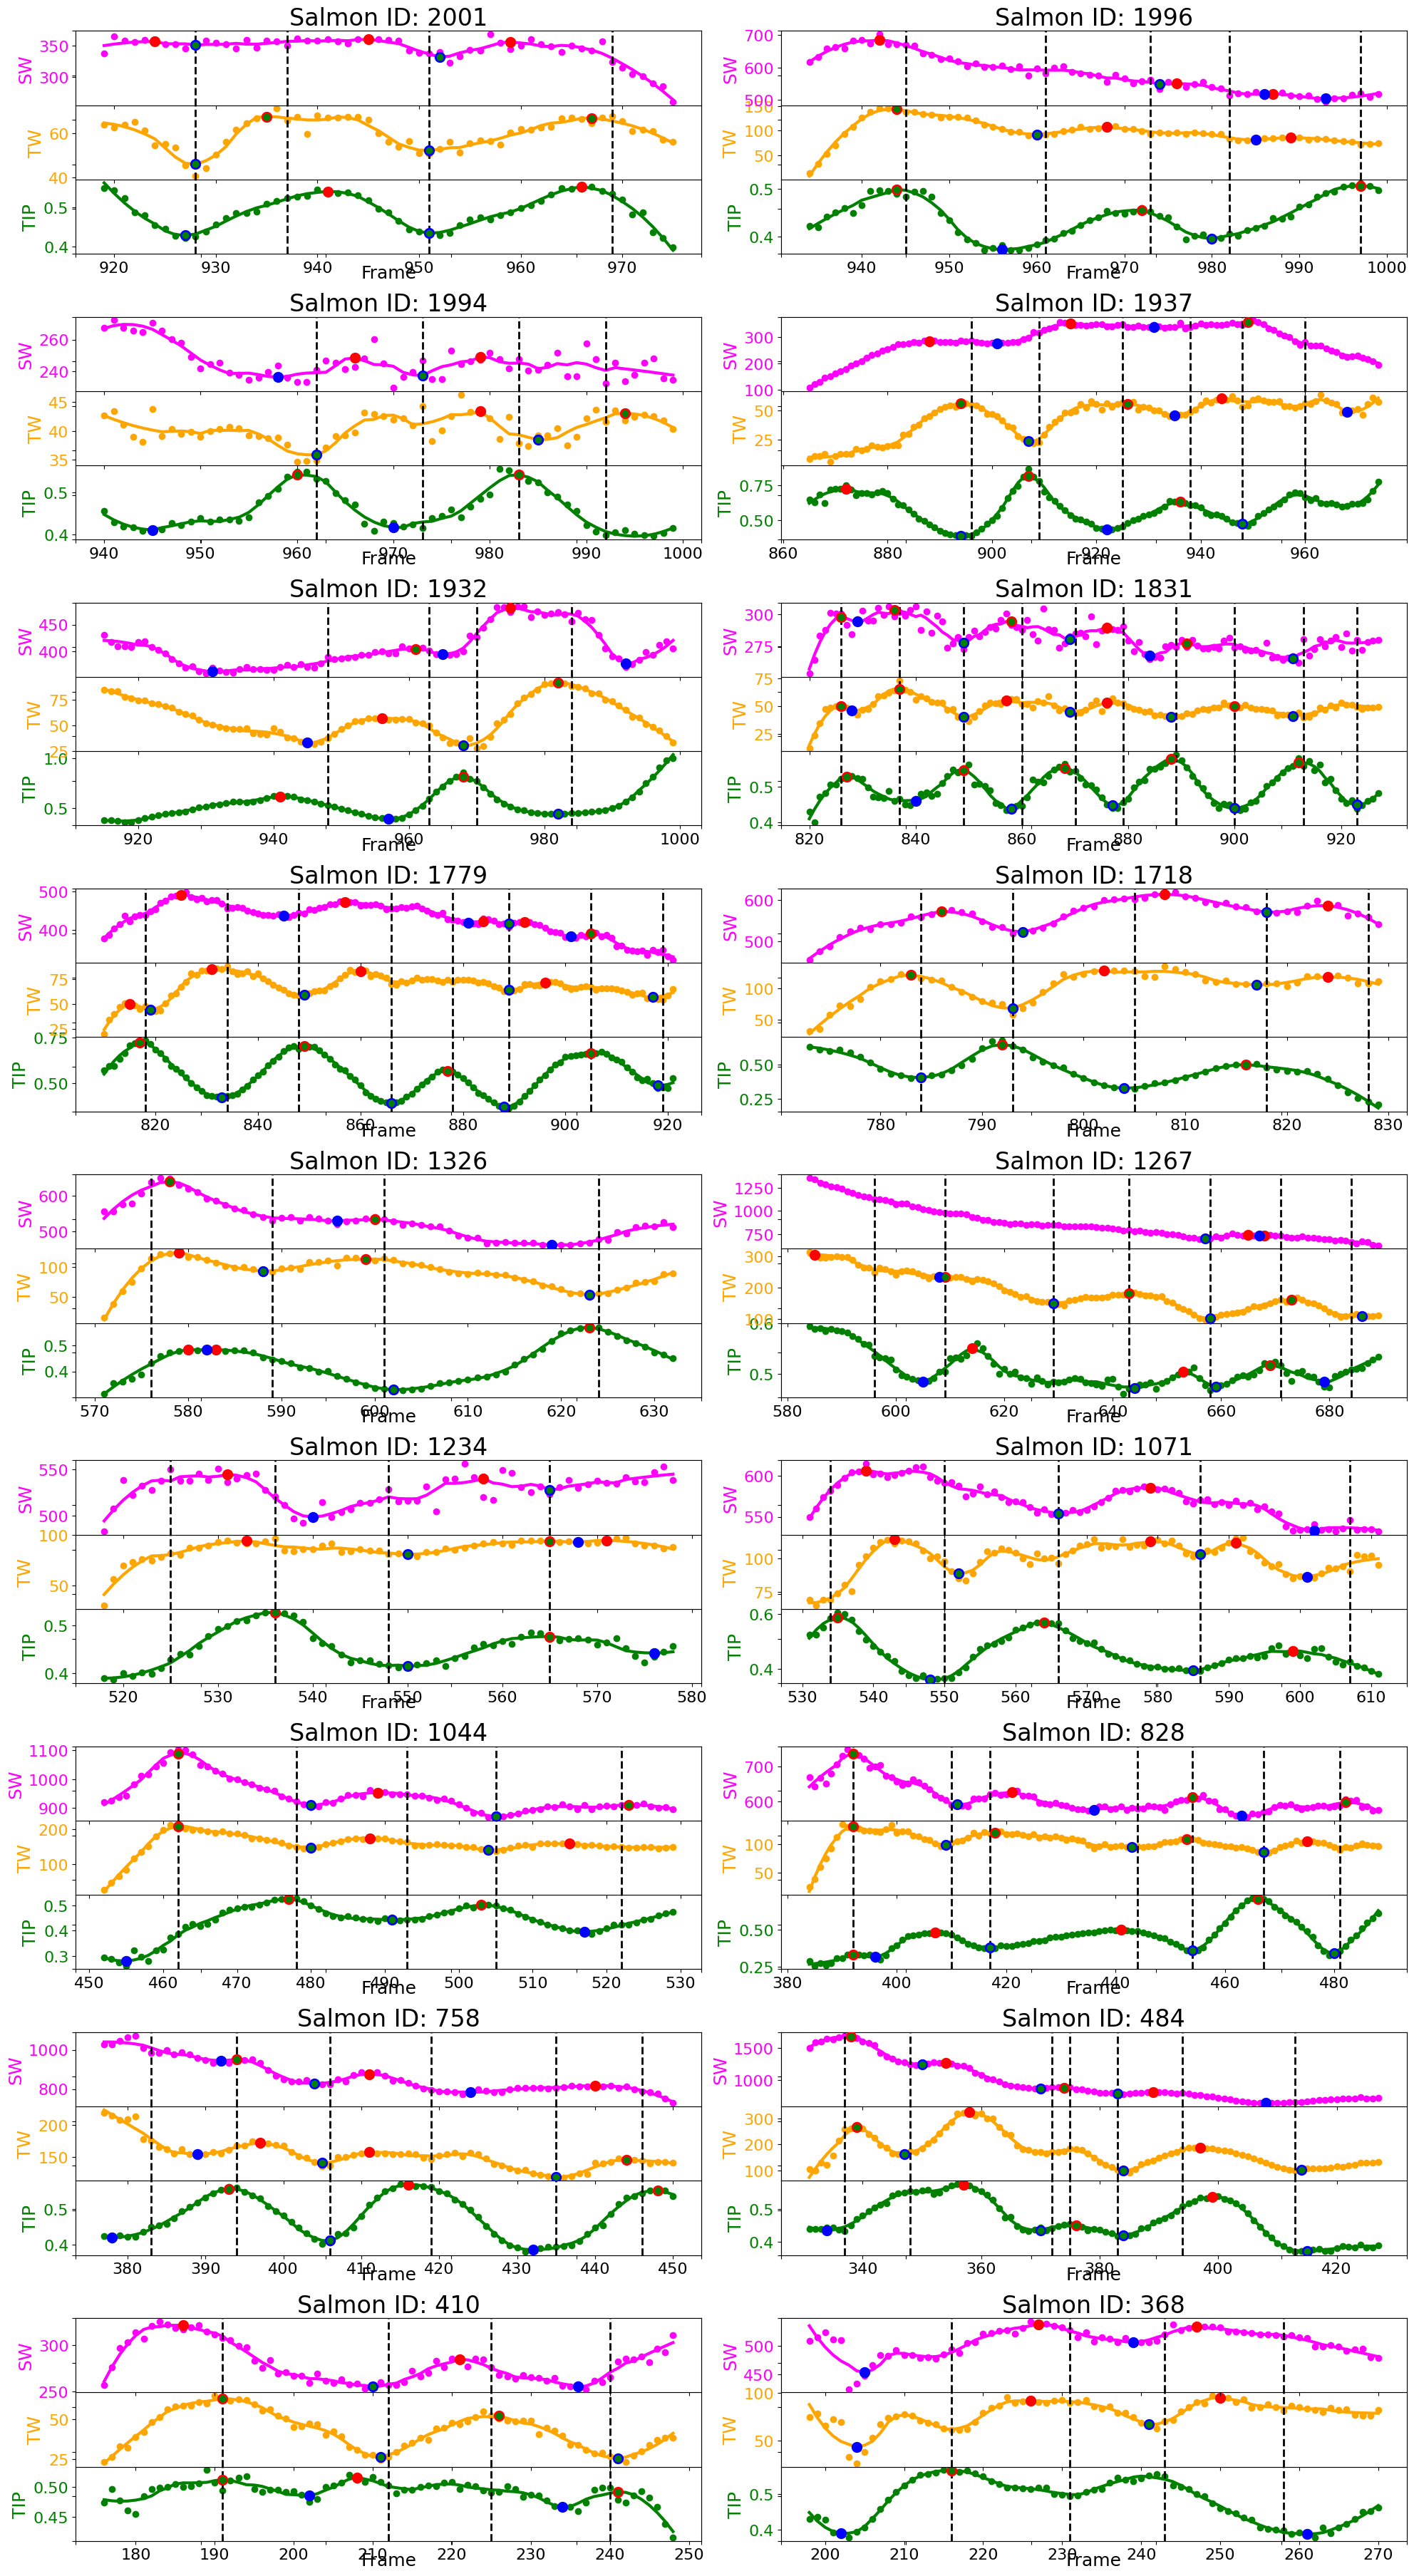

In [6]:
# Load gt
gt_dict = load_gt(gt_path)

# Calculate tail beat results and plot time series
valid_ids = list(gt_dict.keys())
plot_ids = valid_ids
plot_ids = [p for p in plot_ids if len(gt_dict[p]) > 0]
#plot_ids = ['368', '410', '828', '1779', '1831', '1937']
num_rows = 20
num_cols = 2
threshes = [1, 2, 3, 4]
plt.figure(figsize=(20, 80))
TP_dict = {'tip': [], 'salmon_width': [], 'tailfin_width': []}
FP_dict = {'tip': [], 'salmon_width': [], 'tailfin_width': []}
FN_dict = {'tip': [], 'salmon_width': [], 'tailfin_width': []}

for i, id in enumerate(plot_ids):
    # Subplot
    plt.subplot(num_rows, num_cols, i + 1)
    plt.title(f'Salmon ID: {id}', fontsize=24)
    plt.xlabel('Frame', fontsize=18)
    plt.grid()

    # Find data
    id_trks = trackers[trackers[:,1] == str(id), :]

    # Initialize data dictionaries
    tailfin_width_dict = {}
    salmon_width_dict = {}
    tip_dict = {}

    frames = list(set(list(id_trks[:,0].astype(int))))
    frames.sort()
    for frame in frames:
        # Calculate different representations
        tailfin = id_trks[np.bitwise_and(id_trks[:,-1] == 'tail_fin', id_trks[:,0] == str(frame)),:]
        head = id_trks[np.bitwise_and(id_trks[:,-1] == 'head', id_trks[:,0] == str(frame)),:]
        body = id_trks[np.bitwise_and(id_trks[:,-1] == 'body', id_trks[:,0] == str(frame)),:]
        adi_fin = id_trks[np.bitwise_and(id_trks[:,-1] == 'adi_fin', id_trks[:,0] == str(frame)),:]
        anal_fin = id_trks[np.bitwise_and(id_trks[:,-1] == 'anal_fin', id_trks[:,0] == str(frame)),:]
        salmon = id_trks[np.bitwise_and(id_trks[:,-1] == 'salmon', id_trks[:,0] == str(frame)),:]
        salmon_width_dict[frame] = float(salmon[0,4])

        if len(adi_fin) > 0 and len(anal_fin) > 0 and len(body) > 0 and len(tailfin) > 0:
            intersec_point = line_intersection((tailfin[0, 2:4].astype(float), body[0, 2:4].astype(float)), (adi_fin[0, 2:4].astype(float), anal_fin[0, 2:4].astype(float)))
            dist_on_line = np.linalg.norm(adi_fin[0, 2:4].astype(float) - intersec_point)/np.linalg.norm(adi_fin[0, 2:4].astype(float)-anal_fin[0, 2:4].astype(float))
            tip_dict[frame] = dist_on_line

        if len(tailfin) > 0:
            tailfin_width_dict[frame] = float(tailfin[0,4])


    # Find tailbeat states for different representations
    num_peaks = len(gt_dict[id])
    tip_maxima, tip_minima, tip_smoothed = find_tailbeat(tip_dict, num_peaks = num_peaks, id = id)
    salmon_width_maxima, salmon_width_minima, salmon_width_smoothed = find_tailbeat(salmon_width_dict, num_peaks = num_peaks, id = id)
    tailfin_width_maxima, tailfin_width_minima, tailfin_width_smoothed = find_tailbeat(tailfin_width_dict, num_peaks = num_peaks, id = id)

    # Calculate metrics
    tip_hyps = np.array(frames)[np.array(list(tip_maxima) + list(tip_minima))]
    tip_gts = [i[1] for i in gt_dict[id]]
    tip_FP, tip_FN, tip_TP, tip_hyp_ind = get_single_track_metrics(tip_hyps, tip_gts, threshes=threshes, id=id)
    if id == '2203':
        print(tip_hyp_ind)
    salmon_width_hyps = np.array(frames)[np.array(list(salmon_width_maxima) + list(salmon_width_minima))]
    salmon_width_gts = [i[1] for i in gt_dict[id]]
    salmon_width_FP, salmon_width_FN, salmon_width_TP, salmon_width_hyp_ind = get_single_track_metrics(salmon_width_hyps, salmon_width_gts, threshes=threshes, id=id)
    tailfin_width_hyps = np.array(frames)[np.array(list(tailfin_width_maxima) + list(tailfin_width_minima))]
    tailfin_width_gts = [i[1] for i in gt_dict[id]]
    tailfin_width_FP, tailfin_width_FN, tailfin_width_TP, tailfin_width_hyp_ind = get_single_track_metrics(tailfin_width_hyps, tailfin_width_gts, threshes=threshes, id=id)

    # Update metrics dictionaries
    TP_dict['tip'].extend(tip_TP)
    TP_dict['salmon_width'].extend(salmon_width_TP)
    TP_dict['tailfin_width'].extend(tailfin_width_TP)
    FN_dict['tip'].extend(tip_FN)
    FN_dict['salmon_width'].extend(salmon_width_FN)
    FN_dict['tailfin_width'].extend(tailfin_width_FN)
    FP_dict['tip'].extend(tip_FP)
    FP_dict['salmon_width'].extend(salmon_width_FP)
    FP_dict['tailfin_width'].extend(tailfin_width_FP)

    # Plot the smoothed signal and mark the peaks
    ax1 = plt.gca()
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    ax_sub1 = ax1.inset_axes([0, 0/3, 1, 1/3])
    plot_ax(ax_sub1, tip_dict, tip_smoothed, tip_maxima, tip_minima, color = 'green')
    ax_sub1.set_ylabel('TIP', color='green', fontsize = 18)

    ax_sub2 = ax1.inset_axes([0, 1/3, 1, 1/3])
    plot_ax(ax_sub2, tailfin_width_dict, tailfin_width_smoothed, tailfin_width_maxima, tailfin_width_minima, color = 'orange')
    ax_sub2.set_ylabel('TW', color='orange', fontsize = 18)
    ax_sub2.set_xticklabels([])

    ax_sub3 = ax1.inset_axes([0, 2/3, 1, 1/3])
    plot_ax(ax_sub3, salmon_width_dict, salmon_width_smoothed, salmon_width_maxima, salmon_width_minima, color = 'magenta')
    ax_sub3.set_ylabel('SW', color='magenta', fontsize = 18)
    ax_sub3.set_xticklabels([])

    # Plot ground-truths
    for gt_item in gt_dict[id]:
        ax_sub1.axvline(x=gt_item[1], color='black', linestyle='--', linewidth=2)
        ax_sub2.axvline(x=gt_item[1], color='black', linestyle='--', linewidth=2)
        ax_sub3.axvline(x=gt_item[1], color='black', linestyle='--', linewidth=2)

    # Plot gt-hyp matches
    for i in tip_hyps[tip_hyp_ind]:
        ax_sub1.scatter(i, tip_smoothed[frames==i][0], zorder = 4, color = 'green')
    for i in salmon_width_hyps[salmon_width_hyp_ind]:
        ax_sub3.scatter(i, salmon_width_smoothed[frames==i][0], zorder = 4, color = 'green')
    for i in tailfin_width_hyps[tailfin_width_hyp_ind]:
        ax_sub2.scatter(i, tailfin_width_smoothed[frames==i][0], zorder = 4, color = 'green')


# Print results
print('TP')
for k in TP_dict.keys():
    print(k + ' ' + str(np.sum(TP_dict[k])/len(threshes)))
print('\n')
print('FP')
for k in FP_dict.keys():
    print(k + ' ' + str(np.sum(FP_dict[k])/len(threshes)))
print('\n')
print('FN')
for k in FN_dict.keys():
    print(k + ' ' + str(np.sum(FN_dict[k])/len(threshes)))
print('\n')

print('Total')
for k in TP_dict.keys():
    print(k + ' ' + str((np.sum(FP_dict[k]) + np.sum(TP_dict[k]))/len(threshes)))
print('\n')

plt.tight_layout()
